### Intro: For new wells, regression is used for prediction. The First 6 months avg. productions are predicted.

### 1. Importing packages

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### 2. Loading datasets
Unfortunately, the train and exam datasets are confidential and therefore, will not be provided in this repository

In [ ]:
train_df = pd.read_csv('trainSet.csv', index_col=1)
exam_df = pd.read_csv('examSet.csv', index_col=1)

In [ ]:
# visualizing missing values in train dataset
train_df_isnull = train_df.isnull()
train_df_isnull = train_df_isnull * 1

x = list(train_df.columns)
y = np.arange(0, train_df.shape[0])
z = train_df_isnull.to_numpy()

fig = go.Figure(go.Heatmap(x=x, y=y, z=z))
fig.update_yaxes(autorange='reversed')
fig.update_layout(title='Missing values in Train dataset')
fig.show()

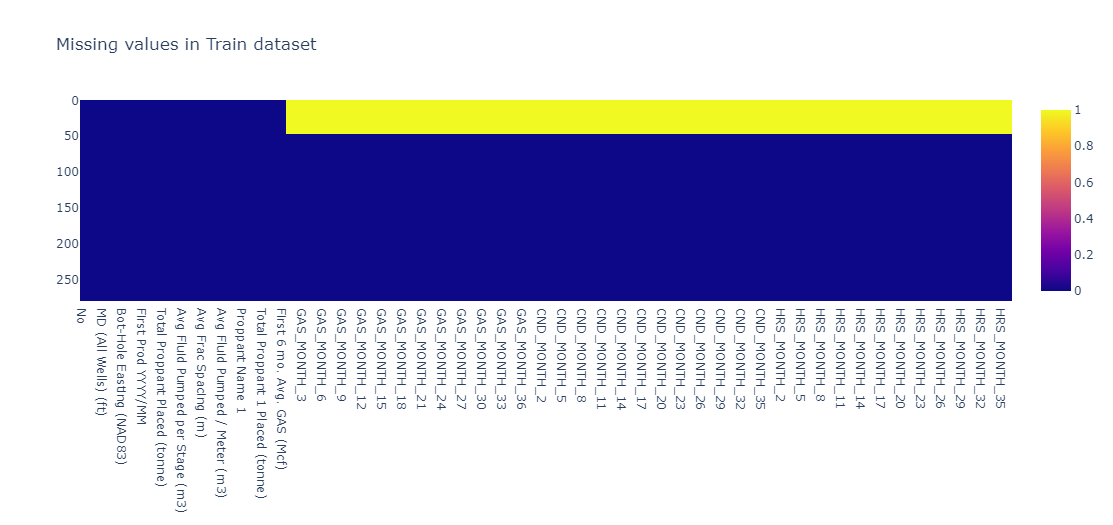

In [ ]:
# visualizing missing values in exam dataset
exam_df_isnull = exam_df.isnull()
exam_df_isnull = exam_df_isnull * 1

x = list(exam_df.columns)
y = np.arange(0, exam_df.shape[0])
z = exam_df_isnull.to_numpy()

fig = go.Figure(go.Heatmap(x=x, y=y, z=z))
fig.update_yaxes(autorange='reversed')
fig.update_layout(title='Missing values in Exam dataset')
fig.show()

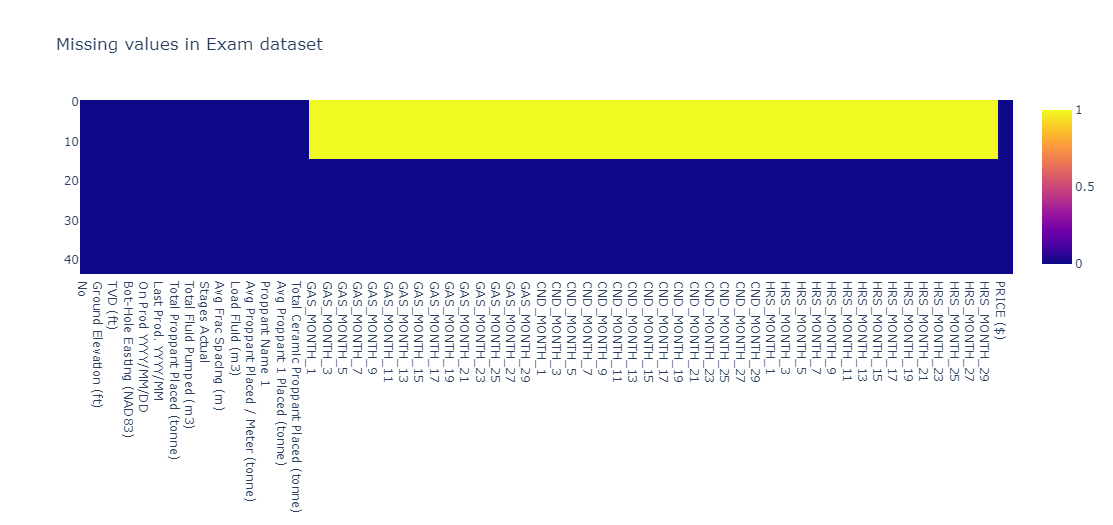

### 3. Feature engineering

In [ ]:
# dropping columns from train dataset
drop_cols = []
for i in range(36):
    drop_cols.append('GAS_MONTH_' + str(i+1))
    drop_cols.append('CND_MONTH_' + str(i+1))
    drop_cols.append('HRS_MONTH_' + str(i+1))
drop_cols.extend(['No', 'Last 6 mo. Avg. GAS (Mcf)'])

XY_train = train_df.drop(drop_cols, axis=1)
XY_train.shape

(280, 30)

In [ ]:
# splitting features and response in train dataset
X_train = XY_train.drop('First 6 mo. Avg. GAS (Mcf)', axis=1)
Y_train = XY_train[['First 6 mo. Avg. GAS (Mcf)']]

print(X_train.shape)
print(Y_train.shape)

(280, 29)
(280, 1)


In [ ]:
# selecting new wells from exam dataset
X_exam = exam_df.iloc[:15,:]

# dropping columns from exam dataset
drop_cols = []
for i in range(30):
    drop_cols.append('GAS_MONTH_' + str(i+1))
    drop_cols.append('CND_MONTH_' + str(i+1))
    drop_cols.append('HRS_MONTH_' + str(i+1))
drop_cols.extend(['No', 'PRICE ($)', 'Per Month Operation Cost ($)'])

X_exam = X_exam.drop(drop_cols, axis=1)
X_exam.shape

(15, 29)

In [ ]:
# combining train and exam features
X_combined = pd.concat([X_train, X_exam], axis=0)
X_combined.shape

(295, 29)

In [ ]:
# dropping unnecessary columns from combined dataset
drop_cols = ['Avg Proppant Placed per Stage (tonne)', 
             'Avg Fluid Pumped per Stage (m3)', 
             'Load Fluid Rec (m3)', 
             'Avg Fluid Pumped / Meter (m3)', 
             'Avg Proppant Placed / Meter (tonne)', 
             'Avg Proppant 1 Placed (tonne)', 
             'Total Ceramic Proppant Placed (tonne)']

X_combined = X_combined.drop(drop_cols, axis=1)
X_combined.shape

(295, 22)

In [ ]:
# function to get categorical columns
def get_cat_cols(df):
    num_cols = df._get_numeric_data().columns
    cat_cols = list(set(df.columns) - set(num_cols))
    return cat_cols

In [ ]:
# getting categorical columns from combined dataset
get_cat_cols(X_combined)

['Last Prod. YYYY/MM',
 'Proppant Name 1',
 'Proppant Size 1',
 'First Prod YYYY/MM',
 'Stimulation Fluid',
 'On Prod YYYY/MM/DD',
 'Proppant Composition']

In [ ]:
# function to convert dates to numerical values
def convert_dates(df):
    df['On Prod YYYY/MM/DD'] = pd.to_datetime(df['On Prod YYYY/MM/DD'], 
                                              format='%Y.%m.%d')
    df['First Prod YYYY/MM'] = pd.to_datetime(df['First Prod YYYY/MM'], 
                                              format='%Y.%m.%d')
    df['Last Prod. YYYY/MM'] = pd.to_datetime(df['Last Prod. YYYY/MM'], 
                                              format='%Y.%m.%d')

    s1 = df['On Prod YYYY/MM/DD'] - df['First Prod YYYY/MM']
    df['FirstProdtoOnProdDays'] = s1.dt.days

    s2 = df['Last Prod. YYYY/MM'] - df['First Prod YYYY/MM']
    df['FirstProdtoLastProdDays'] = s2.dt.days

    df = df.drop(['On Prod YYYY/MM/DD', 
                  'First Prod YYYY/MM', 
                  'Last Prod. YYYY/MM'], axis=1)
    
    return df

In [ ]:
# converting dates to numerical values
X_combined = convert_dates(X_combined)
X_combined.shape

(295, 21)

In [ ]:
# getting remaining categorical columns from combined dataset
cat_cols = get_cat_cols(X_combined)
cat_cols

['Stimulation Fluid',
 'Proppant Size 1',
 'Proppant Name 1',
 'Proppant Composition']

In [ ]:
# imputing 0 values in Proppant Size 1
X_combined['Proppant Size 1'] = np.where(
    (X_combined['Proppant Size 1'] == '0') & (X_combined['Proppant Name 1'] == 'Sand'), 
    '40/70', 
    X_combined['Proppant Size 1'])

In [ ]:
X_combined['Proppant Size 1'] = np.where(
    (X_combined['Proppant Size 1'] == '0') & (X_combined['Proppant Name 1'] == 'HydroProp'), 
    '40/80', 
    X_combined['Proppant Size 1'])

In [ ]:
# getting number of categories in categorical columns
for col in cat_cols:
    print(col + ' : ' + str(len(X_combined[col].unique())))

Stimulation Fluid : 21
Proppant Size 1 : 5
Proppant Name 1 : 13
Proppant Composition : 2


In [ ]:
# creating dummies for categorical columns
X_combined_dummies = pd.get_dummies(data=X_combined, columns=cat_cols)
X_combined_dummies.shape

(295, 58)

### 4. Exploratory Data Analysis (EDA)

In [ ]:
# function to split combined dataset into train and exam
def split_train_exam(X_combined, n):
    X_train = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_train, X_exam

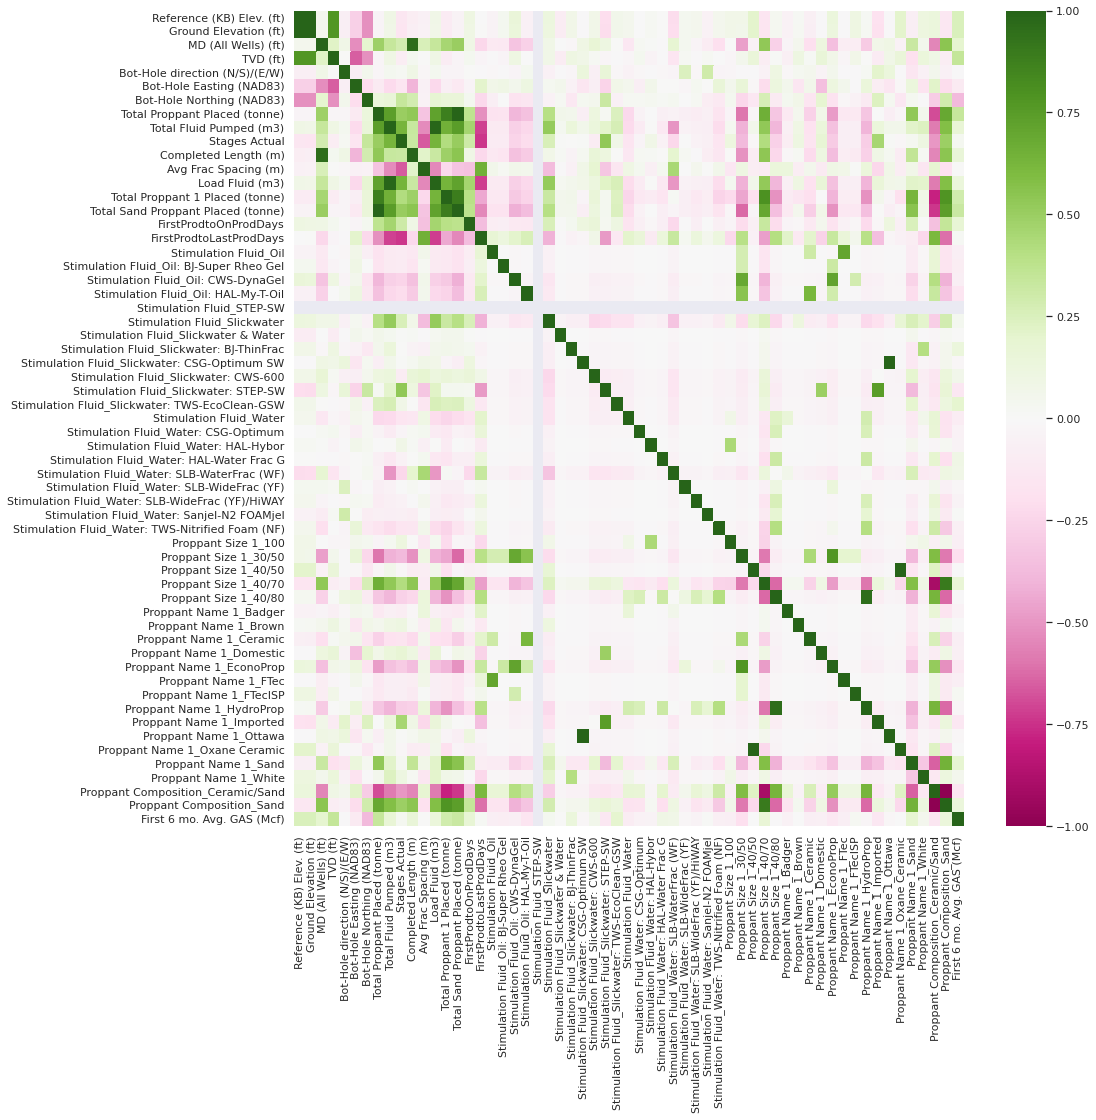

In [ ]:
# creating correlation matrix
X_train, X_exam = split_train_exam(X_combined_dummies, Y_train.shape[0])

XY_train = pd.concat([X_train, Y_train], axis=1)

corr = XY_train.corr()

sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='PiYG')

In [ ]:
# creating correlation scatter plot with response
corr = []
for col in list(X_train.columns):
    c = Y_train['First 6 mo. Avg. GAS (Mcf)'].corr(X_train[col])
    corr.append(c)

fig = go.Figure(go.Scatter(x=X_train.columns, y=corr, mode='markers', 
                           marker_color='chocolate'))
fig.update_layout(title='Corr with First 6 months avg.')
fig.show()

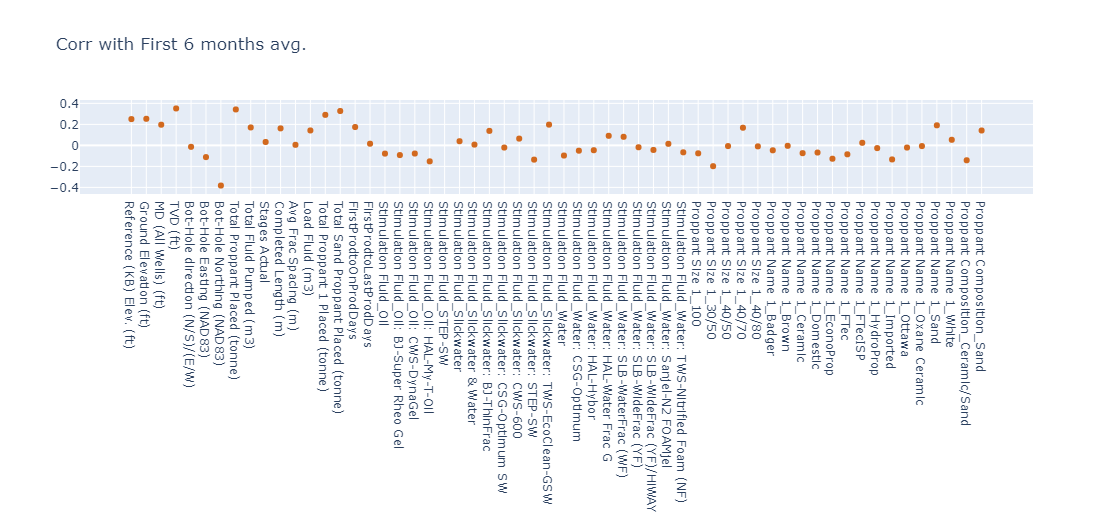

### 5. Modeling and Perfomance evaluation

In [ ]:
# function for performance evaluation
def model_perf(model, X, Y):
    Yhat = model.predict(X)
    Ytrue = Y['First 6 mo. Avg. GAS (Mcf)'].to_numpy()
    smape = 100 / len(Ytrue) * np.sum(2 * np.abs(Yhat - Ytrue) / 
                                   (np.abs(Yhat) + np.abs(Ytrue)))
    return smape

# function for training and validating model
def model_fit_perf(model, X_all, Y_all):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, 
                                                  random_state=42)
    model.fit(X_trn, Y_trn)
    smape = model_perf(model, X_val, Y_val)
    return smape

In [ ]:
# creating models
bagging = BaggingRegressor(n_estimators=50)
random_forest = RandomForestRegressor(n_estimators=50)
xgb = XGBRegressor(max_depth=5, objective='reg:squarederror')
lgbm = LGBMRegressor()

estms = [('b', bagging), ('rf', random_forest), ('xgb', xgb), ('lgbm', lgbm)]
voting = VotingRegressor(estimators=estms)

# training and validating models
b_smape = model_fit_perf(bagging, X_train, Y_train)
rf_smape = model_fit_perf(random_forest, X_train, Y_train)
xgb_smape = model_fit_perf(xgb, X_train, Y_train)
lgbm_smape = model_fit_perf(lgbm, X_train, Y_train)
v_smape = model_fit_perf(voting, X_train, Y_train)

In [ ]:
# comparing performances of models
models = ['Bagging', 'Random Forest', 'XGBoost', 'LGBM', 'Voting']
smapes = [b_smape, rf_smape, xgb_smape, lgbm_smape, v_smape]

fig = go.Figure(go.Bar(x=models, 
                       y=smapes, 
                       text=smapes))

fig.update_traces(texttemplate='%{text:.4f}', textposition='inside')
fig.update_layout(
    title='Models sMAPE scores', 
    xaxis=dict(title='Models'), 
    yaxis=dict(title='Scores')
)
fig.show()

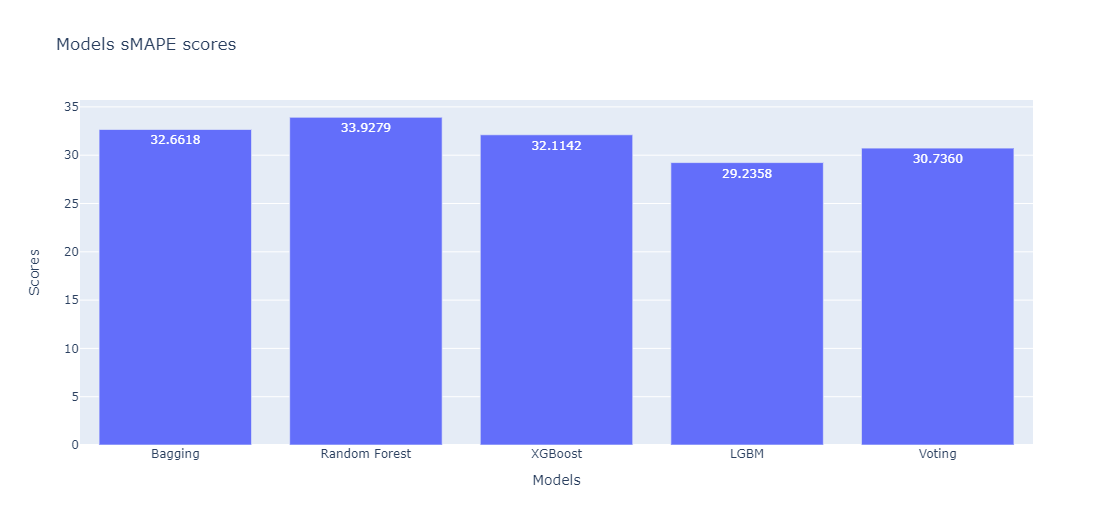

#### Feature importance

In [ ]:
# getting top 10 most important features from lgbm model
feature_results = pd.DataFrame({'Feature': list(X_train.columns), 
                                'Importance': lgbm.feature_importances_})

feature_results = feature_results.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_results['Rank'] = np.arange(1, len(feature_results)+1, 1)
feature_results_rank = feature_results.set_index('Rank')
feature_results_rank = feature_results_rank[['Feature', 'Importance']]
feature_results_rank.head(10)

,Feature,Importance
Rank,,
1,TVD (ft),108
2,Bot-Hole Easting (NAD83),100
3,Bot-Hole Northing (NAD83),87
4,Bot-Hole direction (N/S)/(E/W),64
5,Completed Length (m),60
6,Total Proppant Placed (tonne),48
7,MD (All Wells) (ft),47
8,Avg Frac Spacing (m),42
9,FirstProdtoOnProdDays,41


### 6. Prediction

In [ ]:
# predicting responses for exam dataset
first_6_avg_pred = lgbm.predict(X_exam)

sub_df = pd.read_csv('sub.csv')
sub_df['First 6 Avg'] = first_6_avg_pred

sub_df.to_csv('sub1.csv')